# Training and Inference

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [51]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Enable memory growth to prevent TensorFlow from allocating all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU is available and will be used")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available and will be used


In [52]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

# Import data

In [53]:
TRAIN_EPOCHS = 100
NUM_FEATURES = 1 # univariate time series, SINR or PHR or dlBler
TIME_STEP = 100  # Number of past time steps to use
BATCH_SIZE = 16 # it works for time series

INPUT_WIDTH = 64
LABEL_WIDTH = 64
PREDICTION_STEPS = 64 # prediction steps into the future

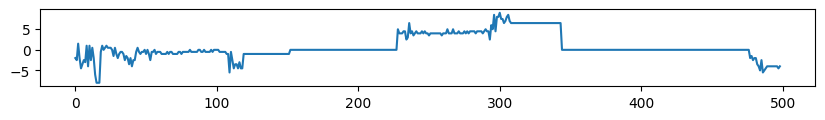

In [54]:
df_raw = pd.read_csv('data_one_feat_sinr_clean.csv', header=None)
plt.figure(figsize=(10, 1))
plot_features = df_raw[0][1:500]
plt.plot(range(len(plot_features)), plot_features)
plt.show()

In [55]:
df = df_raw.copy()
df = df[1:] # full data
print(df.shape)
print(df.head())

(1717, 1)
     0
1 -2.0
2 -2.5
3  1.5
4 -2.0
5 -4.5


In [56]:
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Define the function to create the dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Split the data into training and testing sets
training_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]

# Create the datasets for training and testing
X_train, y_train = create_dataset(train_data, TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

print(X_train.shape, y_train.shape)

# Reshape the input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape)
print(scaled_data.shape)

(1272, 100) (1272,)
(1272, 100, 1) (1272,)
(1717, 1)


In [57]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# GPU Configuration
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Enable mixed precision for faster training
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU enabled with mixed precision")
    except RuntimeError as e:
        print(e)

# Increase batch size for GPU
BATCH_SIZE = 64

# Create optimized datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build model (same as before)
model = Sequential(name='LSTM_model')
model.add(LSTM(100, return_sequences=True, input_shape=(TIME_STEP, NUM_FEATURES)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, dtype='float32'))  # Output layer uses float32 for mixed precision

model.compile(optimizer='adam', loss='mean_squared_error')

# Train with dataset
history = model.fit(train_dataset,
                    epochs=TRAIN_EPOCHS,
                    verbose=1)

Num GPUs Available:  1
GPU enabled with mixed precision
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0515
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
E

In [58]:
model.summary()

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,909 (847.31 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,608 (564.89 KB)

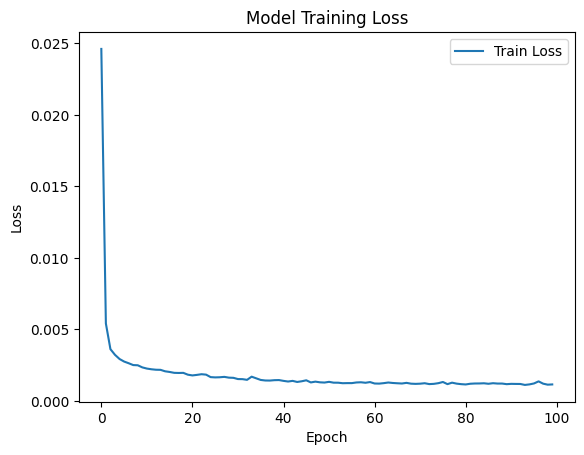

In [59]:
# Plot the training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [60]:
# Convert history.history (dict) to DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv("training_history.csv", index=False)

In [61]:
# Reload history
loaded_history = pd.read_csv("training_history.csv")

In [62]:
model.save("lstm_trained.keras")

# Inference

In [63]:
model = tf.keras.models.load_model('./lstm_trained.keras')

Train RMSE: 1.1997010250692295
Test RMSE: 1.466150489210406


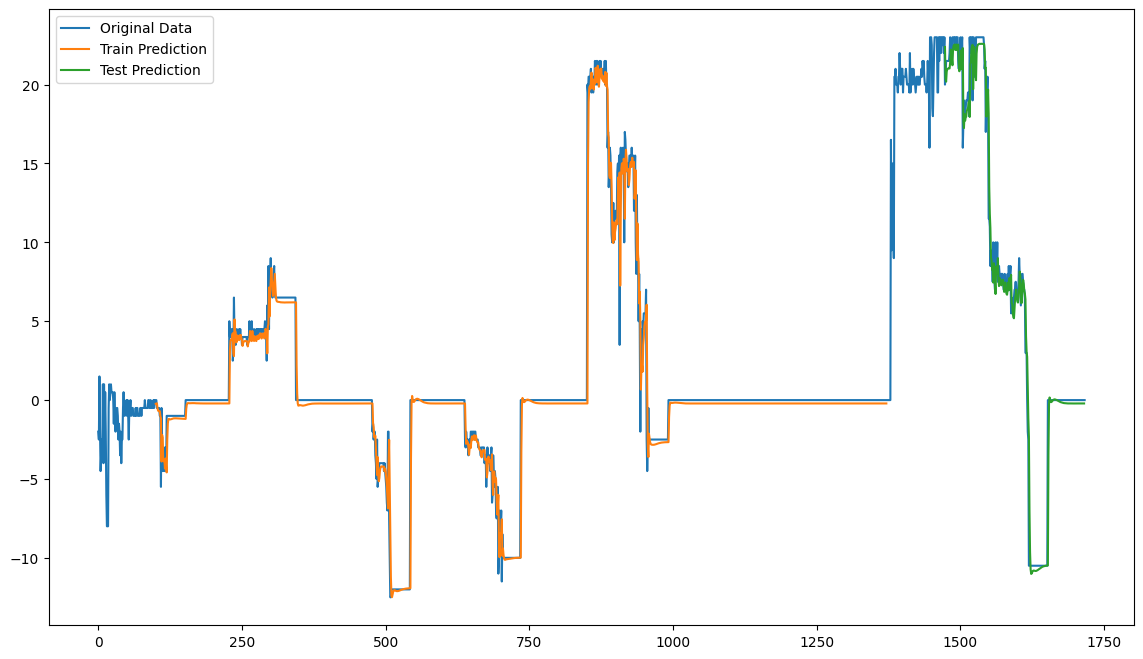

In [64]:
# Make predictions
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

# Transform back to original form (if your data was scaled)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot the results
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[TIME_STEP:len(train_predict) + TIME_STEP, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (TIME_STEP * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 8))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(train_predict_plot, label='Train Prediction')
plt.plot(test_predict_plot, label='Test Prediction')
plt.legend()
plt.show()